**Download dataset from Kaggle (Colab)**

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mubashirsiddique","key":"a25893d75b7b4a21507c2a6b44abaca0"}'}

In [ ]:
# 2) Put kaggle.json into ~/.kaggle and download the dataset
import os
os.makedirs("/root/.kaggle", exist_ok=True)
# If you uploaded kaggle.json via Colab file upload widget, copy it:
# from google.colab import files
# files.upload()  # upload kaggle.json then continue

!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# 3) Download the dataset
!kaggle datasets download -d vishweshsalodkar/customer-feedback-dataset
!unzip -o customer-feedback-dataset.zip


Dataset URL: https://www.kaggle.com/datasets/vishweshsalodkar/customer-feedback-dataset
License(s): other
  0% 0.00/3.52k [00:00<?, ?B/s]
100% 3.52k/3.52k [00:00<00:00, 16.1MB/s]
Archive:  customer-feedback-dataset.zip
  inflating: sentiment-analysis.csv  


In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00


**Imports and helpers**

In [ ]:
# 4) Imports and helpers
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns

# set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


***LOAD CSV***

In [ ]:
# 5) Load CSV (adjust filename if different)
df = pd.read_csv("sentiment-analysis.csv")  # or the correct file name after unzip
df.head()


,"Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score"
0,"""I love this product!"", Positive, Twitter, 202..."
1,"""The service was terrible."", Negative, Yelp Re..."
2,"""This movie is amazing!"", Positive, IMDb, 2023..."
3,"""I'm so disappointed with their customer suppo..."
4,"""Just had the best meal of my life!"", Positive..."


***SPLIT DATASET***

In [ ]:
from google.colab import files
import pandas as pd

# 1️⃣ Upload the file
uploaded = files.upload()  # Choose your CSV file manually

# 2️⃣ Get the filename
filename = list(uploaded.keys())[0]
print("✅ Uploaded file:", filename)

# 3️⃣ Read the file properly
df_raw = pd.read_csv(filename, header=None)

# 4️⃣ Split header and data
header = df_raw.iloc[0, 0].split(",")
df = df_raw.iloc[1:]
df = df[0].str.split(",", expand=True)
df.columns = [h.strip().lower() for h in header]

print("✅ Columns:", df.columns.tolist())
print(df.head())


Saving sentiment-analysis.csv to sentiment-analysis (1).csv
✅ Uploaded file: sentiment-analysis (1).csv
✅ Columns: ['text', 'sentiment', 'source', 'date/time', 'user id', 'location', 'confidence score']
                                                text  sentiment  \
1                             "I love this product!"   Positive   
2                        "The service was terrible."   Negative   
3                           "This movie is amazing!"   Positive   
4  "I'm so disappointed with their customer suppo...   Negative   
5               "Just had the best meal of my life!"   Positive   

          source             date/time       user id      location  \
1        Twitter   2023-06-15 09:23:14      @user123      New York   
2   Yelp Reviews   2023-06-15 11:45:32       user456   Los Angeles   
3           IMDb   2023-06-15 14:10:22   moviefan789        London   
4   Online Forum   2023-06-15 17:35:11    forumuser1       Toronto   
5    TripAdvisor   2023-06-16 08:50:59      

***Preprocessing & label mapping***

In [ ]:
# 6) Inspect columns and unique labels
print(df.columns)
print(df['sentiment'].value_counts())

# 7) Clean simple issues (optional): drop NAs in text or sentiment
df = df.dropna(subset=['text', 'sentiment']).reset_index(drop=True)

# 8) Map labels to integers
label_list = sorted(df['sentiment'].unique())  # e.g. ['negative','neutral','positive']
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}
print("label2id:", label2id)

df['label'] = df['sentiment'].map(label2id)


Index(['text', 'sentiment', 'source', 'date/time', 'user id', 'location',
       'confidence score'],
      dtype='object')
sentiment
Positive    53
Negative    43
Name: count, dtype: int64
label2id: {' Negative': 0, ' Positive': 1}


***Train / Validation split***

In [ ]:
# 9) split
train_df, val_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)
print("train:", len(train_df), "val:", len(val_df))


train: 81 val: 15


**Tokenization & Dataset class**

In [ ]:
# 10) Tokenizer
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LENGTH = 128  # adjust as needed

def preprocess_texts(texts):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors=None  # we'll return lists, not tensors
    )

# 11) Convert to Hugging Face Dataset or custom torch Dataset
from torch.utils.data import Dataset

class FeedbackDataset(Dataset):
    def __init__(self, df):
        self.texts = df['text'].astype(str).tolist()
        self.labels = df['label'].tolist()
        self.encodings = preprocess_texts(df['text'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = FeedbackDataset(train_df)
val_dataset = FeedbackDataset(val_df)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

***Training setup with Hugging Face Trainer***

In [ ]:
# 12) Prepare model
num_labels = len(label_list)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels, id2label=id2label, label2id=label2id)

# 13) Metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1_macro = f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    return {"accuracy": acc, "f1_macro": f1_macro}


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install --upgrade transformers


In [ ]:
!pip install --upgrade transformers datasets evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 12.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.


In [ ]:
import transformers
print(transformers.__version__)


4.57.1


In [ ]:
from transformers import TrainingArguments
import torch

# Use only arguments supported everywhere
training_args = TrainingArguments(
    output_dir="./bert-feedback",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=100,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
)

# Evaluate & save manually in Trainer if your version does not support evaluation_strategy


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"  # disable wandb logging

from transformers import Trainer, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,  # replace tokenizer
    tokenizer=tokenizer,          # optional, still works for now
    args=training_args,
)


In [ ]:
# 15) Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 16) Train
trainer.train()


/tmp/ipython-input-4249731593.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: f223068 (f223068-fast-universuty) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


TrainOutput(global_step=18, training_loss=0.5467749701605903, metrics={'train_runtime': 88.1555, 'train_samples_per_second': 2.756, 'train_steps_per_second': 0.204, 'total_flos': 15983996613120.0, 'train_loss': 0.5467749701605903, 'epoch': 3.0})

***Evaluation: detailed metrics & confusion matrix***

Validation accuracy: 1.0
Validation F1 macro: 1.0
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00         7
    Positive       1.00      1.00      1.00         8

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



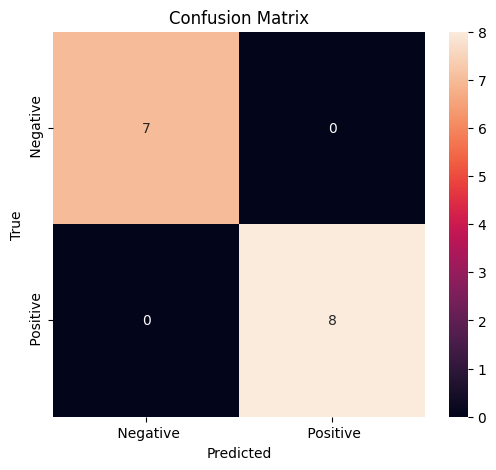

In [ ]:
# 17) Evaluate
eval_results = trainer.predict(val_dataset)
logits = eval_results.predictions
labels = eval_results.label_ids
preds = np.argmax(logits, axis=-1)

# accuracy & f1
acc = accuracy_score(labels, preds)
f1_macro = f1_score(labels, preds, average='macro')
print("Validation accuracy:", acc)
print("Validation F1 macro:", f1_macro)

# classification report
print(classification_report(labels, preds, target_names=[id2label[i] for i in range(num_labels)]))

# confusion matrix (plot)
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=[id2label[i] for i in range(num_labels)], yticklabels=[id2label[i] for i in range(num_labels)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


***Example predictions (inference)***

In [ ]:
# 18) Inference helper
def predict_texts(texts, top_k=None):
    enc = tokenizer(texts, padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        logits = model(**enc).logits
    probs = torch.softmax(logits, dim=-1).cpu().numpy()
    preds = np.argmax(probs, axis=-1)
    results = []
    for i, text in enumerate(texts):
        pred_label = id2label[int(preds[i])]
        pred_prob = float(probs[i, preds[i]])
        if top_k:
            topk_idx = probs[i].argsort()[-top_k:][::-1]
            topk = [(id2label[int(i)], float(probs[i, int(i)])) for i in topk_idx]
        else:
            topk = None
        results.append({"text": text, "pred_label": pred_label, "pred_prob": pred_prob, "topk": topk})
    return results

# 19) Examples
examples = [
    "The delivery was fast and the product quality is excellent. I love it!",
    "Terrible experience. The item arrived damaged and support didn't help.",
    "The product is okay — nothing special, meets expectations."
]

preds = predict_texts(examples, top_k=3)
for p in preds:
    print("Text:", p['text'])
    print("Prediction:", p['pred_label'], f"(prob {p['pred_prob']:.3f})")
    if p['topk']:
        print("Top-k:", p['topk'])
    print()


Text: The delivery was fast and the product quality is excellent. I love it!
Prediction:  Positive (prob 0.673)
Top-k: [(' Positive', 0.43638184666633606), (' Negative', 0.32726505398750305)]

Text: Terrible experience. The item arrived damaged and support didn't help.
Prediction:  Negative (prob 0.564)
Top-k: [(' Negative', 0.32726505398750305), (' Positive', 0.43638184666633606)]

Text: The product is okay — nothing special, meets expectations.
Prediction:  Positive (prob 0.525)
Top-k: [(' Positive', 0.43638184666633606), (' Negative', 0.32726505398750305)]



In [ ]:
# 20) Save
trainer.save_model("./bert-feedback-best")
tokenizer.save_pretrained("./bert-feedback-best")

# 21) Load for later
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model2 = AutoModelForSequenceClassification.from_pretrained("./bert-feedback-best")
tokenizer2 = AutoTokenizer.from_pretrained("./bert-feedback-best")


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# assuming val_dataset.labels exists
true_labels = [item['labels'].item() for item in val_dataset]
preds = trainer.predict(val_dataset).predictions.argmax(axis=-1)

print("Accuracy:", accuracy_score(true_labels, preds))
print("F1 (macro):", f1_score(true_labels, preds, average='macro'))
print(classification_report(true_labels, preds, target_names=[id2label[i] for i in range(len(id2label))]))


Accuracy: 1.0
F1 (macro): 1.0
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00         7
    Positive       1.00      1.00      1.00         8

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



In [ ]:
def predict_texts(texts, top_k=3):
    """
    Predict sentiment for a list of texts.

    Args:
        texts (list of str): Input texts
        top_k (int): Number of top labels to show

    Returns:
        list of dicts with text, predicted label, probability, and top-k labels
    """
    # tokenize
    enc = tokenizer(texts, padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    enc = {k: v.to(device) for k, v in enc.items()}

    # forward pass
    with torch.no_grad():
        logits = model(**enc).logits

    # probabilities
    probs = torch.softmax(logits, dim=-1).cpu().numpy()
    results = []

    for i, text in enumerate(texts):
        pred_idx = probs[i].argmax()
        pred_label = id2label[int(pred_idx)].strip()  # remove spaces
        pred_prob = float(probs[i, pred_idx])

        # top-k labels
        top_indices = probs[i].argsort()[-top_k:][::-1]
        topk = [(id2label[int(idx)].strip(), float(probs[i, idx])) for idx in top_indices]

        results.append({
            "text": text,
            "pred_label": pred_label,
            "pred_prob": pred_prob,
            "topk": topk
        })

    return results


In [ ]:
examples = [
    "The delivery was fast and the product quality is excellent. I love it!",
    "Terrible experience. The item arrived damaged and support didn't help.",
    "The product is okay — nothing special, meets expectations."
]

preds = predict_texts(examples, top_k=3)
for p in preds:
    print("Text:", p['text'])
    print("Prediction:", p['pred_label'], f"(prob {p['pred_prob']:.3f})")
    print("Top-k:", p['topk'])
    print()


Text: The delivery was fast and the product quality is excellent. I love it!
Prediction: Positive (prob 0.673)
Top-k: [('Positive', 0.6727349758148193), ('Negative', 0.32726505398750305)]

Text: Terrible experience. The item arrived damaged and support didn't help.
Prediction: Negative (prob 0.564)
Top-k: [('Negative', 0.5636181831359863), ('Positive', 0.43638184666633606)]

Text: The product is okay — nothing special, meets expectations.
Prediction: Positive (prob 0.525)
Top-k: [('Positive', 0.5254296660423279), ('Negative', 0.47457030415534973)]



In [ ]:
examples = [
    "Absolutely love this! The product arrived on time and works perfectly.",
    "I am very disappointed. The item stopped working after two days.",
    "Excellent service and super fast shipping. Highly recommend!",
    "Worst purchase ever. Customer support was unhelpful and rude.",
    "The product quality is great, exactly as described.",
    "The package came late and the product was broken.",
    "Very satisfied with the purchase, will buy again.",
    "Not worth the money. I regret buying this item.",
    "Amazing experience! Everything went smoothly from order to delivery.",
    "The product is okay but the delivery was delayed."
]

preds = predict_texts(examples, top_k=3)
for p in preds:
    print("Text:", p['text'])
    print("Prediction:", p['pred_label'], f"(prob {p['pred_prob']:.3f})")
    print("Top-k:", p['topk'])
    print()


Text: Absolutely love this! The product arrived on time and works perfectly.
Prediction: Positive (prob 0.641)
Top-k: [('Positive', 0.6410362720489502), ('Negative', 0.3589637875556946)]

Text: I am very disappointed. The item stopped working after two days.
Prediction: Positive (prob 0.532)
Top-k: [('Positive', 0.5318173170089722), ('Negative', 0.46818268299102783)]

Text: Excellent service and super fast shipping. Highly recommend!
Prediction: Positive (prob 0.660)
Top-k: [('Positive', 0.6597272157669067), ('Negative', 0.34027278423309326)]

Text: Worst purchase ever. Customer support was unhelpful and rude.
Prediction: Positive (prob 0.504)
Top-k: [('Positive', 0.5040892958641052), ('Negative', 0.49591073393821716)]

Text: The product quality is great, exactly as described.
Prediction: Positive (prob 0.572)
Top-k: [('Positive', 0.5722148418426514), ('Negative', 0.42778509855270386)]

Text: The package came late and the product was broken.
Prediction: Negative (prob 0.507)
Top-k: [('

In [ ]:
df['sentiment'].value_counts()


,count
sentiment,
Positive,53
Negative,43


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Replace with your model directory if you trained and saved it
model_dir = "./bert-feedback-best"

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)

# Save again to ensure all files are in a folder
model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)


('./bert-feedback-best/tokenizer_config.json',
 './bert-feedback-best/special_tokens_map.json',
 './bert-feedback-best/vocab.txt',
 './bert-feedback-best/added_tokens.json',
 './bert-feedback-best/tokenizer.json')

In [ ]:
import shutil

shutil.make_archive("bert-feedback-best", 'zip', model_dir)


'/content/bert-feedback-best.zip'

In [ ]:
from google.colab import files

files.download("bert-feedback-best.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>